# 点击率预估

点击率预估用来判断一条广告被用户点击的概率，对每次广告的点击做出预测，把用户最有可能点击的广告找出来，是广告技术最重要的算法之一。

## 数据集下载

<img src="criteo.jpg"\>
这次我们使用Kaggle上的[`Display Advertising Challenge`](https://www.kaggle.com/c/criteo-display-ad-challenge/)挑战的criteo数据集。

下载数据集请在终端输入下面命令(脚本文件路径：./data/download.sh)：

wget --no-check-certificate https://s3-eu-west-1.amazonaws.com/criteo-labs/dac.tar.gz

tar zxf dac.tar.gz

rm -f dac.tar.gz

mkdir raw

mv ./*.txt raw/


解压缩以后，train.txt文件11.7G，test.txt文件1.35G。

数据量太大了，我们只使用前100万条数据。

head -n 1000000 test.txt > test_sub100w.txt

head -n 1000000 train.txt > train_sub100w.txt

然后将文件名重新命名为train.txt和test.txt，文件位置不变。

### Data fields

#### Label 
- Target variable that indicates if an ad was clicked (1) or not (0).

#### I1-I13 
- A total of 13 columns of integer features (mostly count features).

#### C1-C26 
- A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. 

数据中含有Label字段，表示这条广告是否被点击，I1-I13一共13个数值特征（Dense Input），C1-C26共26个Categorical类别特征（Sparse Input）。

## 网络模型

<img src='model.png'\>

模型包含三部分网络，一个是FFM(Field-aware Factorization Machines)，一个是FM(Factorization Machine)，另一个是DNN，其中FM网络包含GBDT和FM两个组件。通常在数据预处理的部分，需要做特征交叉组合等特征工程，以便找出帮助我们预测的特征出来，这绝对是技术活。

这次我们跳过特征工程的步骤，把这些组件和深度神经网络组合在一起，将挑选特征的工作交给模型来处理。其中FFM使用了[`LibFFM`](https://www.csie.ntu.edu.tw/~cjlin/libffm/)，FM使用了[`LibFM`](http://www.libfm.org)，GBDT使用了[`LightGBM`](https://github.com/Microsoft/LightGBM)，当然你也可以使用[`xgboost`](http://xgboost.readthedocs.io/en/latest/)。

### GBDT

给入训练数据后，GBDT会训练出若干棵树，我们要使用的是GBDT中每棵树输出的叶子结点，将这些叶子结点作为categorical类别特征输入给FM。有关决策树的使用，请参照Facebook的这篇文章[`Practical Lessons from Predicting Clicks on Ads at Facebook`](http://quinonero.net/Publications/predicting-clicks-facebook.pdf)。
<img src="facebook.png"\>

### FM

FM用来解决数据量大并且特征稀疏下的特征组合问题，先来看看公式（只考虑二阶多项式的情况）：n代表样本的特征数量，$x_i$是第i个特征的值，$w_0$、$w_i$、$w_i$$_j$是模型参数。
<img src="fm_formula.png"\>

从公式可以看出来这是在线性模型基础上，添加了特征组合$x_ix_j$，当然只有在特征$x_i$和$x_j$都不为0时才有意义。然而在实际的应用场景中，训练组合特征的参数是很困难的。因为输入数据普遍存在稀疏性，这导致$x_i$和$x_j$大部分情况都是0，而组合特征的参数$w_i$$_j$只有在特征不为0时才能训练出有意义的值。

比如跟购物相关的特征中，女性可能会更关注化妆品或者首饰之类的物品，而男性可能更关注体育用品或者电子产品等商品，这说明特征组合训练是有意义的。而商品特征可能存在几百上千种分类，通常我们将类别特征转成One hot编码的形式，这样一个特征就要变成几百维的特征，再加上其他的分类特征，这导致输入的特征空间急剧膨胀，所以数据的稀疏性是实际问题中不可避免的挑战。

为了解决二次项参数训练的问题，引入了矩阵分解的概念。在上一篇文章中我们讨论的是电影推荐系统，我们构造了用户特征向量和电影特征向量，通过两个特征向量的点积得到了用户对于某部电影的评分。如果将用户特征矩阵与电影特征矩阵相乘就会得到所有用户对所有影片的评分矩阵。

如果将上面的过程反过来看，实际上对于评分矩阵，我们可以分解成用户矩阵和电影矩阵，而评分矩阵中每一个数据点就相当于上面讨论的组合特征的参数$w_i$$_j$。

对于参数矩阵W，我们采用矩阵分解的方法，将每一个参数$w_i$$_j$分解成两个向量（称之为隐向量）的点积。这样矩阵就可以分解为$W=V^TV$，而每个参数$w_i$$_j$=⟨$v_i$,$v_j$⟩，$v_i$是第i维特征的隐向量，这样FM的二阶公式就变成：
<img src="fm_formula2.png"\>

这就是FM模型的思想。

将GBDT输出的叶子节点作为训练数据的输入，来训练FM模型。这样对于我们的FM网络，需要训练GBDT和FM。看得出来，这次我们的点击率预测网络要复杂了许多，影响最终结果的因素和超参更多了。关于FM和GBDT两个组件的训练我们会在下文进行说明。

### FFM

接下来需要训练FFM模型。FFM在FM的基础上增加了一个Field的概念，比如说一个商品字段，是一个分类特征，可以分成很多不同的feature，但是这些feature都属于同一个Field，或者说同一个categorical的分类特征都可以放到同一个Field。

这可以看成是1对多的关系，打个比方，比如职业字段，这是一个特征，经过One Hot以后，变成了N个特征。那这N个特征其实都属于职业，所以职业就是一个Field。

我们要通过特征组合来训练隐向量，这样每一维特征$x_i$，都会与其他特征的每一种Field $f_j$学习一个隐向量$v_{i,f_j}$。也就是说，隐向量不仅与特征有关，还与Field有关。模型的公式：
<img src="ffm_formula.png"\>

### DNN

我们来看DNN的部分。将输入数据分成两部分，一部分是数值特征（Dense Input），一部分是类别特征（Sparse Input）。我们仍然不适用One Hot编码，将类别特征传入嵌入层，得到多个嵌入向量，再将这些嵌入向量和数值特征连接在一起，传入全连接层，一共连接三层全连接层，使用Relu激活函数。然后再将第三层全连接的输出和FFM、FM的全连接层的输出连接在一起，传入最后一层全连接层。

我们要学习的目标Label表示广告是否被点击了，只有1（点击）和0（没有点击）两种状态。所以我们网络的最后一层要做Logistic回归，在最后一层全连接层使用Sigmoid激活函数，得到广告被点击的概率。

使用LogLoss作为损失函数，FTRL作为学习算法。

FTRL有关的Paper：[`Ad_click_prediction_a_view_from_the_trenches`](https://www.researchgate.net/publication/262412214_Ad_click_prediction_a_view_from_the_trenches)

#### LibFFM和LibFM的代码我做了修改，请使用代码库中我的相关代码。

## 预处理数据集

- 生成神经网络的输入
- 生成FFM的输入
- 生成GBDT的输入

首先要为DNN、FFM和GBDT的输入做预处理。对于数值特征，我们将I1-I13转成0-1之间的小数。类别特征我们将某类别使用次数少于cutoff（超参）的忽略掉，留下使用次数多的feature作为某类别字段的特征，然后将这些特征以各自字段为组进行编号。

比如有C1和C2两个类别字段，C1下面有特征a（大于cutoff次）、b（少于cutoff次）、c（大于cutoff次），C2下面有特征x和y（均大于cutoff次），这样留下来的特征就是C1：a、c和C2：x、y。然后以各自字段为分组进行编号，对于C1字段，a和c的特征id对应0和1；对于C2字段，x和y也是0和1。

对于类别特征的输入数据处理，FFM和GBDT各不相同，我们分别来说。

### GBDT

GBDT的处理要简单一些，C1-C26每个字段各自的特征id值作为输入即可。
GBDT的输入数据格式是：Label I1-I13 C1-C26
所以实际输入可能是这样：0 小数1 小数2 ~ 小数13 1（C1特征Id） 0（C2特征Id） ~ C26特征Id
其中C1特征Id是1，说明此处C1字段的feature是c，而C2字段的feature是x。

下面是一段生成的真实数据：
0	0.05	0.004983	0.05	0	0.021594	0.008	0.15	0.04	0.362	0.166667	0.2	0	0.04	2	3	0	0	1	1	0	3	1	0	0	0	0	3	0	0	1	4	1	3	0	0	2	0	1	0

很抱歉，我的造句能力实在很差，要是上面一段文字看的你很混乱的话，那就直接看代码吧：）

### FFM

FFM的输入数据要复杂一些，详细可以参看官方[`Github`](https://github.com/guestwalk/libffm)上的说明，摘抄如下：

It is important to understand the difference between `field` and `feature`. For example, if we have a raw data like this:

    Click  Advertiser  Publisher
    =====  ==========  =========
    0        Nike        CNN
    1        ESPN        BBC

Here, we have 

    * 2 fields: Advertiser and Publisher
    * 4 features: Advertiser-Nike, Advertiser-ESPN, Publisher-CNN, Publisher-BBC

Usually you will need to build two dictionares, one for field and one for features, like this:
    
    DictField[Advertiser] -> 0
    DictField[Publisher]  -> 1
    
    DictFeature[Advertiser-Nike] -> 0
    DictFeature[Publisher-CNN]   -> 1
    DictFeature[Advertiser-ESPN] -> 2
    DictFeature[Publisher-BBC]   -> 3

Then, you can generate FFM format data:

    0 0:0:1 1:1:1
    1 0:2:1 1:3:1

Note that because these features are categorical, the values here are all ones.


fields应该很好理解，features的划分跟之前GBDT有些不一样，在刚刚GBDT的处理中我们是每个类别内独立编号，C1有features 0~n，C2有features 0~n。而这次FFM是所有的features统一起来编号。你看它的例子，C1是Advertiser，有两个feature，C2是Publisher，有两个feature，统一起来编号就是0~3。而在GBDT我们要独立编号的，看起来像这样：

    DictFeature[Advertiser-Nike] -> 0
    DictFeature[Advertiser-ESPN] -> 1
    DictFeature[Publisher-CNN]   -> 0
    DictFeature[Publisher-BBC]   -> 1 
现在我们假设有第三条数据，看看如何构造FFM的输入数据：

    Click  Advertiser  Publisher
    =====  ==========  =========
    0        Nike        CNN
    1        ESPN        BBC
    0        Lining      CNN

按照规则，应该是像下面这样：

    DictFeature[Advertiser-Nike]   -> 0
    DictFeature[Publisher-CNN]     -> 1
    DictFeature[Advertiser-ESPN]   -> 2
    DictFeature[Publisher-BBC]     -> 3
    DictFeature[Advertiser-Lining] -> 4
在我们这次FFM的输入数据处理中，跟上面略有些区别，每个类别编号以后，下一个类别继续编号，所以最终的features编号是这样的：

    DictFeature[Advertiser-Nike]   -> 0
    DictFeature[Advertiser-ESPN]   -> 1
    DictFeature[Advertiser-Lining] -> 2
    DictFeature[Publisher-CNN]     -> 3
    DictFeature[Publisher-BBC]     -> 4

对于我们的数据是从I1开始编号的，从I1-I13，所以C1的编号要从加13开始。

这是一条来自真实的FFM输入数据：
0	0:0:0.05	1:1:0.004983	2:2:0.05	3:3:0	4:4:0.021594	5:5:0.008	6:6:0.15	7:7:0.04	8:8:0.362	9:9:0.166667	10:10:0.2	11:11:0	12:12:0.04	13:15:1	14:29:1	15:64:1	16:76:1	17:92:1	18:101:1	19:107:1	20:122:1	21:131:1	22:133:1	23:143:1	24:166:1	25:179:1	26:209:1	27:216:1	28:243:1	29:260:1	30:273:1	31:310:1	32:317:1	33:318:1	34:333:1	35:340:1	36:348:1	37:368:1	38:381:1

### DNN

DNN的输入数据就没有那么复杂了，仍然是I1-I13的小数和C1-C26的统一编号，就像FFM一样，只是不需要从加13开始，最后是Label。
真实数据就像这样：
0.05,0.004983,0.05,0,0.021594,0.008,0.15,0.04,0.362,0.166667,0.2,0,0.04,2,16,51,63,79,88,94,109,118,120,130,153,166,196,203,230,247,260,297,304,305,320,
327,335,355,368,0

要说明的就这么多了，我们来看看代码吧，因为要同时生成训练数据、验证数据和测试数据，所以要运行一段时间。

In [1]:
import os
import sys
import click
import random
import collections

import numpy as np
import lightgbm as lgb
import json
import pandas as pd
from sklearn.metrics import mean_squared_error


In [2]:
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


def save_params_with_name(params, name):
    """
    Save parameters to file
    """
    pickle.dump(params, open('{}.p'.format(name), 'wb'))


def load_params_with_name(name):
    """
    Load parameters from file
    """
    return pickle.load(open('{}.p'.format(name), mode='rb'))


以下代码来自百度deep_fm的[`preprocess.py`](https://github.com/PaddlePaddle/models/blob/develop/deep_fm/preprocess.py)，稍稍添了些代码，我就不重复造轮子了：）

In [4]:
# There are 13 integer features and 26 categorical features
continous_features = range(1, 14)
categorial_features = range(14, 40)

# Clip integer features. The clip point for each integer feature
# is derived from the 95% quantile of the total values in each feature
continous_clip = [20, 600, 100, 50, 64000, 500, 100, 50, 500, 10, 10, 10, 50]

class ContinuousFeatureGenerator:
    """
    Normalize the integer features to [0, 1] by min-max normalization
    """

    def __init__(self, num_feature):
        self.num_feature = num_feature
        self.min = [sys.maxsize] * num_feature
        self.max = [-sys.maxsize] * num_feature

    def build(self, datafile, continous_features):
        with open(datafile, 'r') as f:
            for line in f:
                features = line.rstrip('\n').split('\t')
                for i in range(0, self.num_feature):
                    val = features[continous_features[i]]
                    if val != '':
                        val = int(val)
                        if val > continous_clip[i]:
                            val = continous_clip[i]
                        self.min[i] = min(self.min[i], val)
                        self.max[i] = max(self.max[i], val)

    def gen(self, idx, val):
        if val == '':
            return 0.0
        val = float(val)
        return (val - self.min[idx]) / (self.max[idx] - self.min[idx])

class CategoryDictGenerator:
    """
    Generate dictionary for each of the categorical features
    """

    def __init__(self, num_feature):
        self.dicts = []
        self.num_feature = num_feature
        for i in range(0, num_feature):
            self.dicts.append(collections.defaultdict(int))

    def build(self, datafile, categorial_features, cutoff=0):
        with open(datafile, 'r') as f:
            for line in f:
                features = line.rstrip('\n').split('\t')
                for i in range(0, self.num_feature):
                    if features[categorial_features[i]] != '':
                        self.dicts[i][features[categorial_features[i]]] += 1
        for i in range(0, self.num_feature):
            self.dicts[i] = filter(lambda x: x[1] >= cutoff,
                                   self.dicts[i].items())

            self.dicts[i] = sorted(self.dicts[i], key=lambda x: (-x[1], x[0]))
            vocabs, _ = list(zip(*self.dicts[i]))
            self.dicts[i] = dict(zip(vocabs, range(1, len(vocabs) + 1)))
            self.dicts[i]['<unk>'] = 0

    def gen(self, idx, key):
        if key not in self.dicts[idx]:
            res = self.dicts[idx]['<unk>']
        else:
            res = self.dicts[idx][key]
        return res

    def dicts_sizes(self):
        return list(map(len, self.dicts))

In [5]:
def preprocess(datadir, outdir):
    """
    All the 13 integer features are normalzied to continous values and these
    continous features are combined into one vecotr with dimension 13.

    Each of the 26 categorical features are one-hot encoded and all the one-hot
    vectors are combined into one sparse binary vector.
    """
    dists = ContinuousFeatureGenerator(len(continous_features))
    dists.build(os.path.join(datadir, 'train.txt'), continous_features)

    dicts = CategoryDictGenerator(len(categorial_features))
    dicts.build(
        os.path.join(datadir, 'train.txt'), categorial_features, cutoff=200)#200 50

    dict_sizes = dicts.dicts_sizes()
    categorial_feature_offset = [0]
    for i in range(1, len(categorial_features)):
        offset = categorial_feature_offset[i - 1] + dict_sizes[i - 1]
        categorial_feature_offset.append(offset)

    random.seed(0)

    # 90% of the data are used for training, and 10% of the data are used
    # for validation.
    train_ffm = open(os.path.join(outdir, 'train_ffm.txt'), 'w')
    valid_ffm = open(os.path.join(outdir, 'valid_ffm.txt'), 'w')

    train_lgb = open(os.path.join(outdir, 'train_lgb.txt'), 'w')
    valid_lgb = open(os.path.join(outdir, 'valid_lgb.txt'), 'w')

    with open(os.path.join(outdir, 'train.txt'), 'w') as out_train:
        with open(os.path.join(outdir, 'valid.txt'), 'w') as out_valid:
            with open(os.path.join(datadir, 'train.txt'), 'r') as f:
                for line in f:
                    features = line.rstrip('\n').split('\t')
                    continous_feats = []
                    continous_vals = []
                    for i in range(0, len(continous_features)):

                        val = dists.gen(i, features[continous_features[i]])
                        continous_vals.append(
                            "{0:.6f}".format(val).rstrip('0').rstrip('.'))
                        continous_feats.append(
                            "{0:.6f}".format(val).rstrip('0').rstrip('.'))#('{0}'.format(val))

                    categorial_vals = []
                    categorial_lgb_vals = []
                    for i in range(0, len(categorial_features)):
                        val = dicts.gen(i, features[categorial_features[i]]) + categorial_feature_offset[i]
                        categorial_vals.append(str(val))
                        val_lgb = dicts.gen(i, features[categorial_features[i]])
                        categorial_lgb_vals.append(str(val_lgb))

                    continous_vals = ','.join(continous_vals)
                    categorial_vals = ','.join(categorial_vals)
                    label = features[0]
                    if random.randint(0, 9999) % 10 != 0:
                        out_train.write(','.join(
                            [continous_vals, categorial_vals, label]) + '\n')
                        train_ffm.write('\t'.join(label) + '\t')
                        train_ffm.write('\t'.join(
                            ['{}:{}:{}'.format(ii, ii, val) for ii,val in enumerate(continous_vals.split(','))]) + '\t')
                        train_ffm.write('\t'.join(
                            ['{}:{}:1'.format(ii + 13, str(np.int32(val) + 13)) for ii, val in enumerate(categorial_vals.split(','))]) + '\n')
                        
                        train_lgb.write('\t'.join(label) + '\t')
                        train_lgb.write('\t'.join(continous_feats) + '\t')
                        train_lgb.write('\t'.join(categorial_lgb_vals) + '\n')

                    else:
                        out_valid.write(','.join(
                            [continous_vals, categorial_vals, label]) + '\n')
                        valid_ffm.write('\t'.join(label) + '\t')
                        valid_ffm.write('\t'.join(
                            ['{}:{}:{}'.format(ii, ii, val) for ii,val in enumerate(continous_vals.split(','))]) + '\t')
                        valid_ffm.write('\t'.join(
                            ['{}:{}:1'.format(ii + 13, str(np.int32(val) + 13)) for ii, val in enumerate(categorial_vals.split(','))]) + '\n')
                                                
                        valid_lgb.write('\t'.join(label) + '\t')
                        valid_lgb.write('\t'.join(continous_feats) + '\t')
                        valid_lgb.write('\t'.join(categorial_lgb_vals) + '\n')
                        
    train_ffm.close()
    valid_ffm.close()

    train_lgb.close()
    valid_lgb.close()

    test_ffm = open(os.path.join(outdir, 'test_ffm.txt'), 'w')
    test_lgb = open(os.path.join(outdir, 'test_lgb.txt'), 'w')

    with open(os.path.join(outdir, 'test.txt'), 'w') as out:
        with open(os.path.join(datadir, 'test.txt'), 'r') as f:
            for line in f:
                features = line.rstrip('\n').split('\t')

                continous_feats = []
                continous_vals = []
                for i in range(0, len(continous_features)):
                    val = dists.gen(i, features[continous_features[i] - 1])
                    continous_vals.append(
                        "{0:.6f}".format(val).rstrip('0').rstrip('.'))
                    continous_feats.append(
                            "{0:.6f}".format(val).rstrip('0').rstrip('.'))#('{0}'.format(val))

                categorial_vals = []
                categorial_lgb_vals = []
                for i in range(0, len(categorial_features)):
                    val = dicts.gen(i,
                                    features[categorial_features[i] -
                                             1]) + categorial_feature_offset[i]
                    categorial_vals.append(str(val))

                    val_lgb = dicts.gen(i, features[categorial_features[i] - 1])
                    categorial_lgb_vals.append(str(val_lgb))

                continous_vals = ','.join(continous_vals)
                categorial_vals = ','.join(categorial_vals)

                out.write(','.join([continous_vals, categorial_vals]) + '\n')
                
                test_ffm.write('\t'.join(['{}:{}:{}'.format(ii, ii, val) for ii,val in enumerate(continous_vals.split(','))]) + '\t')
                test_ffm.write('\t'.join(
                    ['{}:{}:1'.format(ii + 13, str(np.int32(val) + 13)) for ii, val in enumerate(categorial_vals.split(','))]) + '\n')
                                                                
                test_lgb.write('\t'.join(continous_feats) + '\t')
                test_lgb.write('\t'.join(categorial_lgb_vals) + '\n')

    test_ffm.close()
    test_lgb.close()
    return dict_sizes

In [7]:
dict_sizes = preprocess('./data/raw','./data')

In [8]:
save_params_with_name((dict_sizes), 'dict_sizes') #pickle.dump((dict_sizes), open('dict_sizes.p', 'wb'))

In [ ]:
dict_sizes = load_params_with_name('dict_sizes') #pickle.load(open('dict_sizes.p', mode='rb'))

In [9]:
sum(dict_sizes)

8496

## 训练FFM

数据准备好了，开始调用LibFFM，训练FFM模型。

learning rate是0.1，迭代32次，训练好后保存的模型文件是model_ffm。

In [12]:
import subprocess, sys, os, time

NR_THREAD = 1

In [17]:
cmd = './libffm/libffm/ffm-train --auto-stop -r 0.1 -t 32 -s {nr_thread} -p ./data/valid_ffm.txt ./data/train_ffm.txt model_ffm'.format(nr_thread=NR_THREAD) 
os.popen(cmd).readlines()

['First check if the text file has already been converted to binary format (1.3 seconds)\n',
 'Binary file found. Skip converting text to binary\n',
 'First check if the text file has already been converted to binary format (0.2 seconds)\n',
 'Binary file found. Skip converting text to binary\n',
 'iter   tr_logloss   va_logloss      tr_time\n',
 '   1      0.49339      0.48196         12.8\n',
 '   2      0.47621      0.47651         25.9\n',
 '   3      0.47149      0.47433         39.0\n',
 '   4      0.46858      0.47277         51.2\n',
 '   5      0.46630      0.47168         63.0\n',
 '   6      0.46447      0.47092         74.7\n',
 '   7      0.46269      0.47038         86.4\n',
 '   8      0.46113      0.47000         98.0\n',
 '   9      0.45960      0.46960        109.6\n',
 '  10      0.45811      0.46940        121.2\n',
 '  11      0.45660      0.46913        132.5\n',
 '  12      0.45509      0.46899        144.3\n',
 '  13      0.45366      0.46903\n',
 'Auto-stop. Us

FFM模型训练好了，我们把训练、验证和测试数据输入给FFM，得到FFM层的输出，输出的文件名为*.out.logit

In [19]:
cmd = './libffm/libffm/ffm-predict ./data/train_ffm.txt model_ffm tr_ffm.out'.format(nr_thread=NR_THREAD) 
os.popen(cmd).readlines()

['logloss = 0.45308\n']

In [20]:
cmd = './libffm/libffm/ffm-predict ./data/valid_ffm.txt model_ffm va_ffm.out'.format(nr_thread=NR_THREAD) 
os.popen(cmd).readlines()

['logloss = 0.46899\n']

In [21]:
cmd = './libffm/libffm/ffm-predict ./data/test_ffm.txt model_ffm te_ffm.out true'.format(nr_thread=NR_THREAD) 
os.popen(cmd).readlines()

['done!\n']

## 训练GBDT

现在调用LightGBM训练GBDT模型，因为决策树较容易过拟合，我们设置树的个数为32，叶子节点数设为30，深度就不设置了，学习率设为0.05。

In [22]:
def lgb_pred(tr_path, va_path, _sep = '\t', iter_num = 32):
    # load or create your dataset
    print('Load data...')
    df_train = pd.read_csv(tr_path, header=None, sep=_sep)
    df_test = pd.read_csv(va_path, header=None, sep=_sep)
    
    y_train = df_train[0].values
    y_test = df_test[0].values
    X_train = df_train.drop(0, axis=1).values
    X_test = df_test.drop(0, axis=1).values
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    # specify your configurations as a dict
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'auc', 'logloss'},
        'num_leaves': 30,
#         'max_depth': 7,
        'num_trees': 32,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }
    
    print('Start training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=iter_num,
                    valid_sets=lgb_eval,
                    feature_name=["I1","I2","I3","I4","I5","I6","I7","I8","I9","I10","I11","I12","I13","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26"],
                    categorical_feature=["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26"],
                    early_stopping_rounds=5)
    
    print('Save model...')
    # save model to file
    gbm.save_model('lgb_model.txt')
    
    print('Start predicting...')
    # predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # eval
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

    return gbm,y_pred,X_train,y_train

In [23]:
gbm,y_pred,X_train ,y_train = lgb_pred('./data/train_lgb.txt', './data/valid_lgb.txt', '\t', 256)

Load data...
Start training...


/Applications/anaconda/envs/tensorflow1.0/lib/python3.5/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Applications/anaconda/envs/tensorflow1.0/lib/python3.5/site-packages/lightgbm/basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Applications/anaconda/envs/tensorflow1.0/lib/python3.5/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's l2: 0.241954	valid_0's auc: 0.70607
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.234704	valid_0's auc: 0.715608
[3]	valid_0's l2: 0.228139	valid_0's auc: 0.717791
[4]	valid_0's l2: 0.222168	valid_0's auc: 0.72273
[5]	valid_0's l2: 0.216728	valid_0's auc: 0.724065
[6]	valid_0's l2: 0.211819	valid_0's auc: 0.725036
[7]	valid_0's l2: 0.207316	valid_0's auc: 0.727427
[8]	valid_0's l2: 0.203296	valid_0's auc: 0.728583
[9]	valid_0's l2: 0.199582	valid_0's auc: 0.730092
[10]	valid_0's l2: 0.196185	valid_0's auc: 0.730792
[11]	valid_0's l2: 0.193063	valid_0's auc: 0.732316
[12]	valid_0's l2: 0.190268	valid_0's auc: 0.733773
[13]	valid_0's l2: 0.187697	valid_0's auc: 0.734782
[14]	valid_0's l2: 0.185351	valid_0's auc: 0.735636
[15]	valid_0's l2: 0.183215	valid_0's auc: 0.736346
[16]	valid_0's l2: 0.181241	valid_0's auc: 0.737393
[17]	valid_0's l2: 0.179468	valid_0's auc: 0.737709
[18]	valid_0's l2: 0.177829	valid_0's auc: 0.739096
[19]	valid_0's

#### 查看每个特征的重要程度

In [24]:
gbm.feature_importance()

array([ 15,   0,  30,  10,  12,  79,  31,  15,  14,   0,  44,   0,  29,
         0,  16,   0,  65,   0,   0,  32,   0,   0,  29,  30,  10, 120,
        30, 165,  19,  11,  69,   1,   0,   2,   0,   6,  39,   0,   5])

In [25]:
gbm.feature_importance("gain")

array([  69634.31561279,       0.        ,   17624.44689941,
          4734.61398315,   10529.7180481 ,  199794.76257324,
         94191.14331055,   13543.23699951,   10014.74700928,
             0.        ,  191050.53414917,       0.        ,
         28020.85171509,       0.        ,    6852.7729187 ,
             0.        ,   32251.70903015,       0.        ,
             0.        ,   14341.38494873,       0.        ,
             0.        ,   11129.02203369,   12486.21105957,
          5218.96902466,   99722.85806274,   23106.2180481 ,
         79130.2718811 ,   10490.07904053,   17757.50100708,
         34302.44396973,     424.67401123,       0.        ,
           882.20599365,       0.        ,    3156.61196899,
         15901.01004028,       0.        ,    3397.2270813 ])

#### 我们把每个特征的重要程度排个序看看

In [26]:
def ret_feat_impt(gbm):
    gain = gbm.feature_importance("gain").reshape(-1, 1) / sum(gbm.feature_importance("gain"))
    col = np.array(gbm.feature_name()).reshape(-1, 1)
    return sorted(np.column_stack((col, gain)),key=lambda x: x[1],reverse=True)

In [27]:
ret_feat_impt(gbm)

[array(['I6', '0.1978774213012332'],
       dtype='<U32'), array(['I11', '0.1892171073393491'],
       dtype='<U32'), array(['C13', '0.09876586224832032'],
       dtype='<U32'), array(['I7', '0.09328723289667494'],
       dtype='<U32'), array(['C15', '0.07837089393651243'],
       dtype='<U32'), array(['I1', '0.06896606612740637'],
       dtype='<U32'), array(['C18', '0.03397325870627491'],
       dtype='<U32'), array(['C4', '0.03194220375573926'],
       dtype='<U32'), array(['I13', '0.027751948092299045'],
       dtype='<U32'), array(['C14', '0.022884477973766117'],
       dtype='<U32'), array(['C17', '0.01758709018584479'],
       dtype='<U32'), array(['I3', '0.01745531293913725'],
       dtype='<U32'), array(['C24', '0.015748415135270675'],
       dtype='<U32'), array(['C7', '0.014203757070472703'],
       dtype='<U32'), array(['I8', '0.013413268591324624'],
       dtype='<U32'), array(['C11', '0.012366386458128355'],
       dtype='<U32'), array(['C10', '0.011022221770323784'],
   

#### 保存GBDT参数

In [28]:
dump = gbm.dump_model()

In [29]:
save_params_with_name((gbm, dump), 'gbm_dump') 

In [ ]:
gbm, dump = load_params_with_name('gbm_dump') 

#### 通过eli5分析参数
超级慢，看看就好，谨慎运行代码

In [30]:
import eli5 

from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [31]:
import csv
import numpy as np

with open('./data/train_eli5.csv', 'rt') as f:
    data = list(csv.DictReader(f))
data[:1]

[{'C1': '2',
  'C10': '7450',
  'C11': '11013',
  'C12': '11623',
  'C13': '14481',
  'C14': '14962',
  'C15': '15302',
  'C16': '16935',
  'C17': '18436',
  'C18': '18472',
  'C19': '19603',
  'C2': '152',
  'C20': '20105',
  'C21': '20107',
  'C22': '21538',
  'C23': '21549',
  'C24': '22706',
  'C25': '23114',
  'C26': '24074',
  'C3': '556',
  'C4': '1896',
  'C5': '3633',
  'C6': '3684',
  'C7': '6847',
  'C8': '6887',
  'C9': '6966',
  'I1': '0.05',
  'I10': '0.125',
  'I11': '0.2',
  'I12': '0',
  'I13': '0.04',
  'I2': '0.004983',
  'I3': '0.05',
  'I4': '0',
  'I5': '0.021594',
  'I6': '0.008',
  'I7': '0.15',
  'I8': '0.04',
  'I9': '0.362',
  'clicked': '0'}]

In [32]:
_all_xs = [{k: v for k, v in row.items() if k != 'clicked'} for row in data]
_all_ys = np.array([int(row['clicked']) for row in data])

all_xs, all_ys = shuffle(_all_xs, _all_ys, random_state=0)
train_xs, valid_xs, train_ys, valid_ys = train_test_split(
    all_xs, all_ys, test_size=0.25, random_state=0)
print('{} items total, {:.1%} true'.format(len(all_xs), np.mean(all_ys)))

899991 items total, 25.5% true


In [33]:
# from xgboost import XGBClassifier
import warnings
# xgboost <= 0.6a2 shows a warning when used with scikit-learn 0.18+
warnings.filterwarnings('ignore', category=UserWarning)
class CSCTransformer:
    def transform(self, xs):
        # work around https://github.com/dmlc/xgboost/issues/1238#issuecomment-243872543
        return xs.tocsc()
    def fit(self, *args):
        return self

clf =  lgb.LGBMClassifier()
vec = DictVectorizer()
pipeline = make_pipeline(vec, CSCTransformer(), clf)

def evaluate(_clf):
    scores = cross_val_score(_clf, all_xs, all_ys, scoring='accuracy', cv=10)
    print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(scores), 2 * np.std(scores)))
    _clf.fit(train_xs, train_ys)  # so that parts of the original pipeline are fitted

evaluate(pipeline)

Accuracy: 0.776 ± 0.003


In [34]:
booster = clf.booster_   #如果运行出错请使用这句clf.booster()
original_feature_names = booster.feature_name
booster.feature_names = vec.get_feature_names()
# recover original feature names
booster.feature_names = original_feature_names

In [35]:
from eli5 import show_weights
show_weights(clf, vec=vec)

Weight,Feature
0.1726,I1=0
0.0591,I11=0
0.0585,I11=0.1
0.0482,I13=0
0.0330,I6=0
0.0268,I7=0
0.0238,C17=18436
0.0234,C14=14963
0.0162,C14=14960
0.0162,C14=14966


In [36]:
from eli5 import show_prediction
show_prediction(clf, valid_xs[1], vec=vec, show_feature_values=True)

## 用LightGBM的输出生成FM数据

数据格式请参见[`libFM 1.4.2 manual`](http://www.libfm.org/libfm-1.42.manual.pdf)中的说明，截取文档中的格式说明如下：
<img src="fm_format.png"\>

GBDT已经训练好了，我们需要GBDT输出的叶子节点作为输入数据X传给FM，一共30个叶子节点，那么输入给FM的数据格式就是X中不是0的数据的index:value。

一段真实数据如下：0	0:31	1:61	2:93	3:108	4:149	5:182	6:212	7:242	8:277	9:310	10:334	11:365	12:401	13:434	14:465	15:491	16:527	17:552	18:589	19:619	20:648	21:678	22:697	23:744	24:770	25:806	26:826	27:862	28:899	29:928	30:955	31:988

In [37]:
def generat_lgb2fm_data(outdir, gbm, dump, tr_path, va_path, te_path, _sep = '\t'):
    with open(os.path.join(outdir, 'train_lgb2fm.txt'), 'w') as out_train:
        with open(os.path.join(outdir, 'valid_lgb2fm.txt'), 'w') as out_valid:
            with open(os.path.join(outdir, 'test_lgb2fm.txt'), 'w') as out_test:
                df_train_ = pd.read_csv(tr_path, header=None, sep=_sep)
                df_valid_ = pd.read_csv(va_path, header=None, sep=_sep)
                df_test_= pd.read_csv(te_path, header=None, sep=_sep)

                y_train_ = df_train_[0].values
                y_valid_ = df_valid_[0].values                

                X_train_ = df_train_.drop(0, axis=1).values
                X_valid_ = df_valid_.drop(0, axis=1).values
                X_test_= df_test_.values
   
                train_leaves= gbm.predict(X_train_, num_iteration=gbm.best_iteration, pred_leaf=True)
                valid_leaves= gbm.predict(X_valid_, num_iteration=gbm.best_iteration, pred_leaf=True)
                test_leaves= gbm.predict(X_test_, num_iteration=gbm.best_iteration, pred_leaf=True)

                tree_info = dump['tree_info']
                tree_counts = len(tree_info)
                for i in range(tree_counts):
                    train_leaves[:, i] = train_leaves[:, i] + tree_info[i]['num_leaves'] * i + 1
                    valid_leaves[:, i] = valid_leaves[:, i] + tree_info[i]['num_leaves'] * i + 1
                    test_leaves[:, i] = test_leaves[:, i] + tree_info[i]['num_leaves'] * i + 1
#                     print(train_leaves[:, i])
#                     print(tree_info[i]['num_leaves'])

                for idx in range(len(y_train_)):            
                    out_train.write((str(y_train_[idx]) + '\t'))
                    out_train.write('\t'.join(
                        ['{}:{}'.format(ii, val) for ii,val in enumerate(train_leaves[idx]) if float(val) != 0 ]) + '\n')
                    
                for idx in range(len(y_valid_)):                   
                    out_valid.write((str(y_valid_[idx]) + '\t'))
                    out_valid.write('\t'.join(
                        ['{}:{}'.format(ii, val) for ii,val in enumerate(valid_leaves[idx]) if float(val) != 0 ]) + '\n')
                    
                for idx in range(len(X_test_)):                   
                    out_test.write('\t'.join(
                        ['{}:{}'.format(ii, val) for ii,val in enumerate(test_leaves[idx]) if float(val) != 0 ]) + '\n')


In [38]:
generat_lgb2fm_data('./data', gbm, dump, './data/train_lgb.txt', './data/valid_lgb.txt', './data/test_lgb.txt', '\t')

## 训练FM
为训练FM的数据已经准备好了，我们调用LibFM进行训练。

迭代64次，使用sgd训练，学习率是0.00000001，训练好的模型保存为文件fm_model。

训练输出的log，Train和Test的数值不是loss，是accuracy。

In [39]:
cmd = './libfm/libfm/bin/libFM -task c -train ./data/train_lgb2fm.txt -test ./data/valid_lgb2fm.txt -dim ’1,1,8’ -iter 64 -method sgd -learn_rate 0.00000001 -regular ’0,0,0.01’ -init_stdev 0.1 -save_model fm_model'
os.popen(cmd).readlines()

['----------------------------------------------------------------------------\n',
 'libFM\n',
 '  Version: 1.4.4\n',
 '  Author:  Steffen Rendle, srendle@libfm.org\n',
 '  WWW:     http://www.libfm.org/\n',
 'This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.\n',
 'This is free software, and you are welcome to redistribute it under certain\n',
 'conditions; for details see license.txt.\n',
 '----------------------------------------------------------------------------\n',
 'Loading train...\t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=899991\tnum_values=28799712\tnum_features=32\tmin_target=0\tmax_target=1\n',
 'Loading test... \t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 '#relations: 0\n',
 'Loading meta data...\t\n',
 'learnrate=1e-08\n',
 'learnrates=1e-08,1e-08,1e-08\n',
 '#iterations=64\n',
 "SGD: DON'T FORGET TO SHUFFLE THE ROWS IN TRAINING DATA TO GET THE BEST RESULT

FM模型训练好了，我们把训练、验证和测试数据输入给FM，得到FM层的输出，输出的文件名为*.fm.logits

In [40]:
cmd = './libfm/libfm/bin/libFM -task c -train ./data/train_lgb2fm.txt -test ./data/valid_lgb2fm.txt -dim ’1,1,8’ -iter 32 -method sgd -learn_rate 0.00000001 -regular ’0,0,0.01’ -init_stdev 0.1 -load_model fm_model -train_off true -prefix tr'
os.popen(cmd).readlines()

['----------------------------------------------------------------------------\n',
 'libFM\n',
 '  Version: 1.4.4\n',
 '  Author:  Steffen Rendle, srendle@libfm.org\n',
 '  WWW:     http://www.libfm.org/\n',
 'This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.\n',
 'This is free software, and you are welcome to redistribute it under certain\n',
 'conditions; for details see license.txt.\n',
 '----------------------------------------------------------------------------\n',
 'Loading train...\t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=899991\tnum_values=28799712\tnum_features=32\tmin_target=0\tmax_target=1\n',
 'Loading test... \t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 '#relations: 0\n',
 'Loading meta data...\t\n',
 'Reading FM model... \t\n',
 'Final\tTrain=0.761987\tTest=0.758982\n']

In [41]:
cmd = './libfm/libfm/bin/libFM -task c -train ./data/valid_lgb2fm.txt -test ./data/valid_lgb2fm.txt -dim ’1,1,8’ -iter 32 -method sgd -learn_rate 0.00000001 -regular ’0,0,0.01’ -init_stdev 0.1 -load_model fm_model -train_off true -prefix va'
os.popen(cmd).readlines()

['----------------------------------------------------------------------------\n',
 'libFM\n',
 '  Version: 1.4.4\n',
 '  Author:  Steffen Rendle, srendle@libfm.org\n',
 '  WWW:     http://www.libfm.org/\n',
 'This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.\n',
 'This is free software, and you are welcome to redistribute it under certain\n',
 'conditions; for details see license.txt.\n',
 '----------------------------------------------------------------------------\n',
 'Loading train...\t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 'Loading test... \t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 '#relations: 0\n',
 'Loading meta data...\t\n',
 'Reading FM model... \t\n',
 'Final\tTrain=0.758982\tTest=0.758982\n']

In [42]:
cmd = './libfm/libfm/bin/libFM -task c -train ./data/test_lgb2fm.txt -test ./data/valid_lgb2fm.txt -dim ’1,1,8’ -iter 32 -method sgd -learn_rate 0.00000001 -regular ’0,0,0.01’ -init_stdev 0.1 -load_model fm_model -train_off true -prefix te -test2predict true'
os.popen(cmd).readlines()

['----------------------------------------------------------------------------\n',
 'libFM\n',
 '  Version: 1.4.4\n',
 '  Author:  Steffen Rendle, srendle@libfm.org\n',
 '  WWW:     http://www.libfm.org/\n',
 'This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.\n',
 'This is free software, and you are welcome to redistribute it under certain\n',
 'conditions; for details see license.txt.\n',
 '----------------------------------------------------------------------------\n',
 'Loading train...\t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=1000000\tnum_values=32000000\tnum_features=32\tmin_target=0\tmax_target=1\n',
 'Loading test... \t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 '#relations: 0\n',
 'Loading meta data...\t\n',
 'Reading FM model... \t\n',
 'Final\tTest=0.758982\n']

## 开始构建模型

In [3]:
embed_dim = 32
sparse_max = 30000 # sparse_feature_dim = 117568
sparse_dim = 26
dense_dim = 13
out_dim = 400

#### 全数据迭代器

In [4]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

#### 下采样数据迭代器

In [5]:
def get_batches_downsample(Xs, ys, batch_size):
    ind_0 = ys==0
    ind_1 = ys==1
    Xs_0 = Xs[ind_0]
    ys_0 = ys[ind_0]
    Xs_1 = Xs[ind_1]
    ys_1 = ys[ind_1]
    sampling_ind = np.random.permutation(Xs_0.shape[0])[:Xs_1.shape[0]]
    Xs_0_sampling = Xs_0[sampling_ind]
    ys_0_sampling = ys_0[sampling_ind]
    Xs_downsampled = np.concatenate((Xs_0_sampling, Xs_1))
    ys_downsampled = np.concatenate((ys_0_sampling, ys_1))
    downsampled_ind = np.random.permutation(Xs_downsampled.shape[0])
    Xs_downsampled = Xs_downsampled[downsampled_ind]
    ys_downsampled = ys_downsampled[downsampled_ind]
    for start in range(0, len(Xs_downsampled), batch_size):
        end = min(start + batch_size, len(Xs_downsampled))
        yield Xs_downsampled[start:end], ys_downsampled[start:end]

#### 构建计算图
如前所述，将FFM和FM层的输出经过全连接层，再和数值特征、嵌入向量的三层全连接层的输出连接在一起，做Logistic回归。

采用LogLoss损失，实现这段代码时TensorFlow2.0还没有提供FTRL方法，所以这里使用Adam优化损失。

In [6]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import datetime
from sklearn.metrics import log_loss
# from sklearn.learning_curve import learning_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics as sk_metrics

MODEL_DIR = "./models"


class ctr_network(object):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        self.best_loss = 9999

        self.losses = {'train': [], 'test': []}
        self.pred_lst = []
        self.test_y_lst = []
        
        # 定义输入
        dense_input = tf.keras.layers.Input(shape=(dense_dim,), name='dense_input')
        sparse_input = tf.keras.layers.Input(shape=(sparse_dim,), name='sparse_input')
        FFM_input = tf.keras.layers.Input(shape=(1,), name='FFM_input')
        FM_input = tf.keras.layers.Input(shape=(1,), name='FM_input')

        # 输入类别特征，从嵌入层获得嵌入向量
        sparse_embed_layer = tf.keras.layers.Embedding(sparse_max, embed_dim, input_length=sparse_dim)(sparse_input)
        sparse_embed_layer = tf.keras.layers.Reshape([sparse_dim * embed_dim])(sparse_embed_layer)

        # 输入数值特征，和嵌入向量链接在一起经过三层全连接层
        input_combine_layer = tf.keras.layers.concatenate([dense_input, sparse_embed_layer])  # (?, 845 = 832 + 13)
        fc1_layer = tf.keras.layers.Dense(out_dim, name="fc1_layer", activation='relu')(input_combine_layer)
        fc2_layer = tf.keras.layers.Dense(out_dim, name="fc2_layer", activation='relu')(fc1_layer)
        fc3_layer = tf.keras.layers.Dense(out_dim, name="fc3_layer", activation='relu')(fc2_layer)

        ffm_fc_layer = tf.keras.layers.Dense(1, name="ffm_fc_layer")(FFM_input)
        fm_fc_layer = tf.keras.layers.Dense(1, name="fm_fc_layer")(FM_input)
        feature_combine_layer = tf.keras.layers.concatenate([ffm_fc_layer, fm_fc_layer, fc3_layer], 1)  # (?, 402)

        logits_output = tf.keras.layers.Dense(1, name="logits_layer", activation='sigmoid')(feature_combine_layer)

        self.model = tf.keras.Model(inputs=[dense_input, sparse_input, FFM_input, FM_input], outputs=[logits_output])
        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(0.01)
        self.ComputeLoss = tf.keras.losses.LogLoss()

        if tf.io.gfile.exists(MODEL_DIR):
            #             print('Removing existing model dir: {}'.format(MODEL_DIR))
            #             tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

#         self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
#         self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_metrics(self, labels, pred):
        correct_prediction = tf.equal(tf.keras.backend.cast(pred > 0.5, 'float32'), labels)
        accuracy = tf.reduce_mean(tf.keras.backend.cast(correct_prediction, 'float32'), name="accuracy")
        return accuracy  

    @tf.function
    def train_step(self, x, y):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        metrics = 0
        with tf.GradientTape() as tape:
            pred = self.model([x[0],
                               x[1],
                               x[2],
                               x[3]], training=True)
            loss = self.ComputeLoss(y, pred)
            metrics = self.compute_metrics(y, pred)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, metrics, pred

    def training(self, train_dataset, test_dataset, downsample_flg=True, epochs=1, log_freq=50):

        train_X, train_y = train_dataset

        for i in range(epochs):
            if downsample_flg:
                train_batches = get_batches_downsample(train_X, train_y, self.batch_size)
                batch_num = (len(train_y[train_y==1])*2 // self.batch_size)
            else:
                train_batches = get_batches(train_X, train_y, self.batch_size)
                batch_num = len(train_X) // self.batch_size

            train_start = time.time()
#             with self.train_summary_writer.as_default():
            if True:
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                avg_acc = tf.keras.metrics.Mean('acc', dtype=tf.float32)
                avg_auc = tf.keras.metrics.Mean('auc', dtype=tf.float32)

                # Datasets can be iterated over like any other Python iterable.
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    if len(x) < self.batch_size:
                        break
                    
                    loss, metrics, pred = self.train_step([x.take([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 1),
                               x.take(
                                   [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                                    36, 37, 38, 39, 40], 1),
                               np.reshape(x.take(0, 1), [self.batch_size, 1]),
                               np.reshape(x.take(1, 1), [self.batch_size, 1])], np.expand_dims(y, 1))
                    avg_loss(loss)
                    avg_acc(metrics)

                    prediction = tf.reshape(pred, y.shape)
                    self.losses['train'].append(loss)

                    if (np.mean(y) != 0):
                        auc = sk_metrics.roc_auc_score(y, prediction)
                    else:
                        auc = -1

                    avg_auc(auc)
                    if tf.equal(self.optimizer.iterations % log_freq, 0):
#                         summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        #                         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=self.optimizer.iterations)
#                         summary_ops_v2.scalar('acc', avg_acc.result(), step=self.optimizer.iterations)

                        rate = log_freq / (time.time() - start)
                        
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{} Loss: {:0.6f} acc: {:0.6f} auc = {} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(), i, batch_i, batch_num, avg_loss.result(), (avg_acc.result()), avg_auc.result(), rate))

                        avg_auc.reset_states()
                        avg_loss.reset_states()
                        
                        avg_acc.reset_states()
                        start = time.time()

            train_end = time.time()
            print('\nTrain time for epoch #{} ({} total steps): {}'.format(i + 1, self.optimizer.iterations.numpy(),
                                                                           train_end - train_start))
#             with self.test_summary_writer.as_default():
            self.testing(test_dataset, self.optimizer.iterations)
            # self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        avg_acc = tf.keras.metrics.Mean('acc', dtype=tf.float32)
        avg_auc = tf.keras.metrics.Mean('auc', dtype=tf.float32)
        avg_prediction = tf.keras.metrics.Mean('prediction', dtype=tf.float32)

        self.pred_lst=[]
        self.test_y_lst=[]
        
        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            if len(x) < self.batch_size:
                break
            
            pred = self.model([x.take([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 1),
                               x.take(
                                   [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                                    36, 37, 38, 39, 40], 1),
                               np.reshape(x.take(0, 1), [self.batch_size, 1]),
                               np.reshape(x.take(1, 1), [self.batch_size, 1])], training=False)
            test_loss = self.ComputeLoss(np.expand_dims(y, 1), pred)
            avg_loss(test_loss)
            acc = self.compute_metrics(np.expand_dims(y, 1), pred)
            avg_acc(acc)

            # 保存测试损失和准确率
            prediction = tf.reshape(pred, y.shape)
            avg_prediction(prediction)
            self.losses['test'].append(test_loss)

            self.pred_lst.append(prediction)
            self.test_y_lst.append(y)

            if (np.mean(y) != 0):
                auc = sk_metrics.roc_auc_score(y, prediction)
            else:
                auc = -1
            avg_auc(auc)

        self.pred_lst = np.concatenate([val for val in self.pred_lst])
        self.test_y_lst = np.concatenate([val for val in self.test_y_lst])
        print('Model test set loss: {:0.6f}  acc: {:0.6f}  auc = {} prediction = {}'.format(
            avg_loss.result(), avg_acc.result(), avg_auc.result(), avg_prediction.result()))
        print(sk_metrics.classification_report(self.test_y_lst, tf.keras.backend.cast((self.pred_lst) > 0.5, 'float32')))
#         summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        #         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=step_num)
#         summary_ops_v2.scalar('acc', avg_acc.result(), step=step_num)

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def predict_click(self, x, axis = 0):
        clicked = self.model([np.reshape(x.take([2,3,4,5,6,7,8,9,10,11,12,13,14],axis), [1 if axis == 0 else len(x.take([2,3,4,5,6,7,8,9,10,11,12,13,14],axis)), 13]),
                               np.reshape(x.take([15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],axis), [1 if axis == 0 else len(x.take([15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],axis)), 26]),
                               np.reshape(x.take(0,axis), [1 if axis == 0 else len(x.take(0,axis)), 1]),
                               np.reshape(x.take(1,axis), [1 if axis == 0 else len(x.take(0,axis)), 1])])

        return (np.int32(np.array(clicked) > 0.5))


#### 超参
数据量太大，我们只跑一个epoch。

In [7]:
# Number of Epochs
num_epochs = 1
# Batch Size
batch_size = 32

# Learning Rate
learning_rate = 0.01
# Show stats for every n number of batches
show_every_n_batches = 25

save_dir = './save'

ffm_tr_out_path = './tr_ffm.out.logit'
ffm_va_out_path = './va_ffm.out.logit'
fm_tr_out_path = './tr.fm.logits'
fm_va_out_path = './va.fm.logits'
train_path = './data/train.txt'
valid_path = './data/valid.txt'

#### 读取FFM的输出

In [8]:
ffm_train = pd.read_csv(ffm_tr_out_path, header=None)    
ffm_train = ffm_train[0].values

ffm_valid = pd.read_csv(ffm_va_out_path, header=None)    
ffm_valid = ffm_valid[0].values

#### 读取FM的输出

In [9]:
fm_train = pd.read_csv(fm_tr_out_path, header=None)    
fm_train = fm_train[0].values

fm_valid = pd.read_csv(fm_va_out_path, header=None)    
fm_valid = fm_valid[0].values

#### 读取数据集

将DNN数据和FM、FFM的输出数据读取出来，并连接在一起

In [10]:
train_data = pd.read_csv(train_path, header=None)    
train_data = train_data.values

valid_data = pd.read_csv(valid_path, header=None)    
valid_data = valid_data.values

cc_train = np.concatenate((ffm_train.reshape(-1, 1), fm_train.reshape(-1, 1), train_data), 1)
cc_valid = np.concatenate((ffm_valid.reshape(-1, 1), fm_valid.reshape(-1, 1), valid_data), 1)

np.random.shuffle(cc_train)
np.random.shuffle(cc_valid)

train_y = cc_train[:,-1].astype(np.float32)
test_y = cc_valid[:,-1].astype(np.float32)

train_X = cc_train[:,0:-1].astype(np.float32)
test_X = cc_valid[:,0:-1].astype(np.float32)


来看训练数据和验证数据的平均点击率

In [55]:
np.mean(train_y)

0.25485810413659693

In [56]:
np.mean(test_y)

0.25576698097171252

## 训练网络

#### 输出验证集上的训练信息
 - 平均准确率
 - 平均损失
 - 平均Auc
 - 预测的平均点击率
 - 精确率、召回率、F1 Score等信息
 
因为数据中大部分都是负例，正例较少，如果模型全部猜0就能有75%的准确率，所以准确率这个指标是不可信的。

我们需要关注正例的精确率和召回率，当然最主要还是要看LogLoss的值，因为比赛采用的评价指标是LogLoss，而不是采用AUC值。

#### 下采样的训练

In [11]:
ctr_net=ctr_network()
ctr_net.training((train_X, train_y), (test_X, test_y), True, 1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sparse_input (InputLayer)       [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 26, 32)       960000      sparse_input[0][0]               
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 13)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 832)          0           embedding[0][0]                  
______________________________________________________________________________________________

Step #2000	Epoch   0 Batch 1999/14335 Loss: 0.529151 acc: 0.729375 auc = 0.8140261769294739 (37.2093023255814 steps/sec)
Step #2050	Epoch   0 Batch 2049/14335 Loss: 0.557891 acc: 0.716250 auc = 0.7891080379486084 (37.35327168323159 steps/sec)
Step #2100	Epoch   0 Batch 2099/14335 Loss: 0.532251 acc: 0.732500 auc = 0.8101654052734375 (37.88728221359869 steps/sec)
Step #2150	Epoch   0 Batch 2149/14335 Loss: 0.550599 acc: 0.730000 auc = 0.7995302081108093 (36.540542687917075 steps/sec)
Step #2200	Epoch   0 Batch 2199/14335 Loss: 0.557508 acc: 0.715000 auc = 0.7869777679443359 (37.44303830464783 steps/sec)
Step #2250	Epoch   0 Batch 2249/14335 Loss: 0.547438 acc: 0.720625 auc = 0.7953441739082336 (37.34381329802815 steps/sec)
Step #2300	Epoch   0 Batch 2299/14335 Loss: 0.525509 acc: 0.738125 auc = 0.8134141564369202 (37.206364683588745 steps/sec)
Step #2350	Epoch   0 Batch 2349/14335 Loss: 0.538389 acc: 0.722500 auc = 0.8014484643936157 (37.445532037982055 steps/sec)
Step #2400	Epoch   0 B

Step #5400	Epoch   0 Batch 5399/14335 Loss: 0.547436 acc: 0.714375 auc = 0.7931330800056458 (37.306246608970994 steps/sec)
Step #5450	Epoch   0 Batch 5449/14335 Loss: 0.542206 acc: 0.733750 auc = 0.8005442023277283 (36.86784880179386 steps/sec)
Step #5500	Epoch   0 Batch 5499/14335 Loss: 0.548141 acc: 0.728750 auc = 0.796895444393158 (37.02927714096079 steps/sec)
Step #5550	Epoch   0 Batch 5549/14335 Loss: 0.525736 acc: 0.736875 auc = 0.8223486542701721 (37.04713513204129 steps/sec)
Step #5600	Epoch   0 Batch 5599/14335 Loss: 0.554656 acc: 0.712500 auc = 0.7868490815162659 (36.89220235938176 steps/sec)
Step #5650	Epoch   0 Batch 5649/14335 Loss: 0.530732 acc: 0.729375 auc = 0.8173730969429016 (36.97511527659772 steps/sec)
Step #5700	Epoch   0 Batch 5699/14335 Loss: 0.556711 acc: 0.724375 auc = 0.7879570126533508 (36.84869987283991 steps/sec)
Step #5750	Epoch   0 Batch 5749/14335 Loss: 0.540755 acc: 0.711250 auc = 0.8052112460136414 (37.009783851703354 steps/sec)
Step #5800	Epoch   0 Ba

Step #8800	Epoch   0 Batch 8799/14335 Loss: 0.540728 acc: 0.743750 auc = 0.8079255819320679 (37.58067522041431 steps/sec)
Step #8850	Epoch   0 Batch 8849/14335 Loss: 0.554323 acc: 0.706875 auc = 0.787272572517395 (36.97778831018819 steps/sec)
Step #8900	Epoch   0 Batch 8899/14335 Loss: 0.545554 acc: 0.718750 auc = 0.7993287444114685 (37.02536115207087 steps/sec)
Step #8950	Epoch   0 Batch 8949/14335 Loss: 0.543750 acc: 0.708125 auc = 0.7935546636581421 (37.19349733820627 steps/sec)
Step #9000	Epoch   0 Batch 8999/14335 Loss: 0.568930 acc: 0.696875 auc = 0.7807722687721252 (37.27512791622964 steps/sec)
Step #9050	Epoch   0 Batch 9049/14335 Loss: 0.560270 acc: 0.713125 auc = 0.7846238613128662 (33.95638871401888 steps/sec)
Step #9100	Epoch   0 Batch 9099/14335 Loss: 0.546645 acc: 0.733750 auc = 0.7994199395179749 (36.165088474744046 steps/sec)
Step #9150	Epoch   0 Batch 9149/14335 Loss: 0.539397 acc: 0.726250 auc = 0.803443193435669 (36.32575588297753 steps/sec)
Step #9200	Epoch   0 Batc

Step #12150	Epoch   0 Batch 12149/14335 Loss: 0.544207 acc: 0.720000 auc = 0.7956995368003845 (37.32925595208958 steps/sec)
Step #12200	Epoch   0 Batch 12199/14335 Loss: 0.554109 acc: 0.720000 auc = 0.7900136709213257 (37.623521159229966 steps/sec)
Step #12250	Epoch   0 Batch 12249/14335 Loss: 0.550743 acc: 0.722500 auc = 0.7891456484794617 (37.757615836092334 steps/sec)
Step #12300	Epoch   0 Batch 12299/14335 Loss: 0.559745 acc: 0.711875 auc = 0.7795970439910889 (37.6468560780815 steps/sec)
Step #12350	Epoch   0 Batch 12349/14335 Loss: 0.543360 acc: 0.726875 auc = 0.8063113689422607 (37.1248375131596 steps/sec)
Step #12400	Epoch   0 Batch 12399/14335 Loss: 0.548894 acc: 0.706875 auc = 0.7924241423606873 (37.09671741726501 steps/sec)
Step #12450	Epoch   0 Batch 12449/14335 Loss: 0.533258 acc: 0.735000 auc = 0.8040847778320312 (36.619361210457186 steps/sec)
Step #12500	Epoch   0 Batch 12499/14335 Loss: 0.541795 acc: 0.722500 auc = 0.7990156412124634 (37.11531052219775 steps/sec)
Step #1

从训练一轮的结果看，下采样的训练使得网络能够对用户点击预测的更好，跟全数据训练比起来，下采样的数据更均衡。预测成1的recall和f1 score比全数据训练略高一些，说明false negative变少了，提高了用户点击预测的能力。因为网络更主动预测出用户点击事件，造成了false positive增加，导致1的precision降低了一些。采用下采样训练避免了数据不均衡，增加训练次数有助于提高网络的预测能力。

#### 全数据的训练

In [22]:
ctr_net=ctr_network()
ctr_net.training((train_X, train_y), (test_X, test_y), False, 1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sparse_input (InputLayer)       [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 32)       960000      sparse_input[0][0]               
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 13)]         0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 832)          0           embedding_2[0][0]                
____________________________________________________________________________________________

Step #2000	Epoch   0 Batch 1999/28124 Loss: 0.464658 acc: 0.786250 auc = 0.7871505618095398 (37.375100114166685 steps/sec)
Step #2050	Epoch   0 Batch 2049/28124 Loss: 0.439855 acc: 0.811250 auc = 0.8023533821105957 (37.446735566999266 steps/sec)
Step #2100	Epoch   0 Batch 2099/28124 Loss: 0.448711 acc: 0.785625 auc = 0.8157373070716858 (37.51737087589287 steps/sec)
Step #2150	Epoch   0 Batch 2149/28124 Loss: 0.450448 acc: 0.791250 auc = 0.7874497771263123 (37.53739595627864 steps/sec)
Step #2200	Epoch   0 Batch 2199/28124 Loss: 0.412051 acc: 0.812500 auc = 0.8317437767982483 (37.61468778484738 steps/sec)
Step #2250	Epoch   0 Batch 2249/28124 Loss: 0.462334 acc: 0.781875 auc = 0.7887148857116699 (37.32618639990731 steps/sec)
Step #2300	Epoch   0 Batch 2299/28124 Loss: 0.445193 acc: 0.801875 auc = 0.8149371147155762 (37.489913137680084 steps/sec)
Step #2350	Epoch   0 Batch 2349/28124 Loss: 0.470298 acc: 0.785000 auc = 0.7942580580711365 (37.47960172633152 steps/sec)
Step #2400	Epoch   0 

Step #5400	Epoch   0 Batch 5399/28124 Loss: 0.450883 acc: 0.791250 auc = 0.8126479983329773 (37.153177987496036 steps/sec)
Step #5450	Epoch   0 Batch 5449/28124 Loss: 0.449184 acc: 0.782500 auc = 0.8135091662406921 (37.46898134458691 steps/sec)
Step #5500	Epoch   0 Batch 5499/28124 Loss: 0.469559 acc: 0.778125 auc = 0.778247058391571 (37.30374485020617 steps/sec)
Step #5550	Epoch   0 Batch 5549/28124 Loss: 0.440758 acc: 0.784375 auc = 0.8169143199920654 (37.05120628535135 steps/sec)
Step #5600	Epoch   0 Batch 5599/28124 Loss: 0.454368 acc: 0.795000 auc = 0.7780752778053284 (37.61590221220001 steps/sec)
Step #5650	Epoch   0 Batch 5649/28124 Loss: 0.460213 acc: 0.779375 auc = 0.7968864440917969 (37.174799475371664 steps/sec)
Step #5700	Epoch   0 Batch 5699/28124 Loss: 0.441469 acc: 0.801875 auc = 0.8110687136650085 (37.04829355243888 steps/sec)
Step #5750	Epoch   0 Batch 5749/28124 Loss: 0.452034 acc: 0.796875 auc = 0.7928791642189026 (37.594351038027234 steps/sec)
Step #5800	Epoch   0 B

Step #8800	Epoch   0 Batch 8799/28124 Loss: 0.445716 acc: 0.795625 auc = 0.7999676465988159 (37.58641380986417 steps/sec)
Step #8850	Epoch   0 Batch 8849/28124 Loss: 0.445058 acc: 0.795625 auc = 0.7849767208099365 (36.424109866744665 steps/sec)
Step #8900	Epoch   0 Batch 8899/28124 Loss: 0.441962 acc: 0.795625 auc = 0.8166384100914001 (34.50613323864716 steps/sec)
Step #8950	Epoch   0 Batch 8949/28124 Loss: 0.457979 acc: 0.795625 auc = 0.7941118478775024 (34.201787007622514 steps/sec)
Step #9000	Epoch   0 Batch 8999/28124 Loss: 0.454002 acc: 0.789375 auc = 0.7945464253425598 (31.887045629229345 steps/sec)
Step #9050	Epoch   0 Batch 9049/28124 Loss: 0.462069 acc: 0.785625 auc = 0.7970106601715088 (37.118811944275905 steps/sec)
Step #9100	Epoch   0 Batch 9099/28124 Loss: 0.462364 acc: 0.797500 auc = 0.7695688605308533 (37.18441637286546 steps/sec)
Step #9150	Epoch   0 Batch 9149/28124 Loss: 0.444650 acc: 0.782500 auc = 0.8222160339355469 (36.9022190228149 steps/sec)
Step #9200	Epoch   0 

Step #12150	Epoch   0 Batch 12149/28124 Loss: 0.440893 acc: 0.795000 auc = 0.8044201731681824 (36.628667251541756 steps/sec)
Step #12200	Epoch   0 Batch 12199/28124 Loss: 0.478798 acc: 0.764375 auc = 0.7790568470954895 (36.82944793550519 steps/sec)
Step #12250	Epoch   0 Batch 12249/28124 Loss: 0.464058 acc: 0.791875 auc = 0.7964470386505127 (36.38843934407001 steps/sec)
Step #12300	Epoch   0 Batch 12299/28124 Loss: 0.441156 acc: 0.798125 auc = 0.7893115878105164 (36.27085812325318 steps/sec)
Step #12350	Epoch   0 Batch 12349/28124 Loss: 0.460563 acc: 0.778750 auc = 0.7813549041748047 (36.71258353826935 steps/sec)
Step #12400	Epoch   0 Batch 12399/28124 Loss: 0.435011 acc: 0.798750 auc = 0.8206766247749329 (34.08162844096708 steps/sec)
Step #12450	Epoch   0 Batch 12449/28124 Loss: 0.456993 acc: 0.791250 auc = 0.7887585163116455 (33.73159031232031 steps/sec)
Step #12500	Epoch   0 Batch 12499/28124 Loss: 0.440227 acc: 0.790625 auc = 0.7993634939193726 (36.36569830865807 steps/sec)
Step #1

Step #15500	Epoch   0 Batch 15499/28124 Loss: 0.459108 acc: 0.795625 auc = 0.8002208471298218 (36.606564336304935 steps/sec)
Step #15550	Epoch   0 Batch 15549/28124 Loss: 0.439643 acc: 0.806250 auc = 0.8102760910987854 (36.82812207224919 steps/sec)
Step #15600	Epoch   0 Batch 15599/28124 Loss: 0.455807 acc: 0.790000 auc = 0.7853327393531799 (33.952491004537194 steps/sec)
Step #15650	Epoch   0 Batch 15649/28124 Loss: 0.439324 acc: 0.785625 auc = 0.8092612624168396 (35.69128341454199 steps/sec)
Step #15700	Epoch   0 Batch 15699/28124 Loss: 0.444030 acc: 0.793125 auc = 0.8036651015281677 (36.68428854256206 steps/sec)
Step #15750	Epoch   0 Batch 15749/28124 Loss: 0.448921 acc: 0.793750 auc = 0.8023346662521362 (36.42337603376621 steps/sec)
Step #15800	Epoch   0 Batch 15799/28124 Loss: 0.459531 acc: 0.781250 auc = 0.7935079336166382 (36.43568429838332 steps/sec)
Step #15850	Epoch   0 Batch 15849/28124 Loss: 0.454697 acc: 0.788750 auc = 0.8090746998786926 (36.43342452321624 steps/sec)
Step #

Step #18850	Epoch   0 Batch 18849/28124 Loss: 0.456371 acc: 0.784375 auc = 0.7901201844215393 (36.50978520153438 steps/sec)
Step #18900	Epoch   0 Batch 18899/28124 Loss: 0.453902 acc: 0.785000 auc = 0.8017914295196533 (36.79476117070795 steps/sec)
Step #18950	Epoch   0 Batch 18949/28124 Loss: 0.464983 acc: 0.775000 auc = 0.7962169647216797 (36.81703383305133 steps/sec)
Step #19000	Epoch   0 Batch 18999/28124 Loss: 0.450197 acc: 0.775000 auc = 0.7986211180686951 (36.57745635049024 steps/sec)
Step #19050	Epoch   0 Batch 19049/28124 Loss: 0.453710 acc: 0.793750 auc = 0.7889454364776611 (36.6019834149357 steps/sec)
Step #19100	Epoch   0 Batch 19099/28124 Loss: 0.432020 acc: 0.803125 auc = 0.8281852602958679 (36.78726119833931 steps/sec)
Step #19150	Epoch   0 Batch 19149/28124 Loss: 0.446363 acc: 0.786875 auc = 0.8008062243461609 (36.84161799750367 steps/sec)
Step #19200	Epoch   0 Batch 19199/28124 Loss: 0.461770 acc: 0.785000 auc = 0.7861820459365845 (36.53274504256793 steps/sec)
Step #192

Step #22200	Epoch   0 Batch 22199/28124 Loss: 0.439919 acc: 0.797500 auc = 0.8111783862113953 (36.86766732479854 steps/sec)
Step #22250	Epoch   0 Batch 22249/28124 Loss: 0.439600 acc: 0.797500 auc = 0.8037758469581604 (36.77701015985529 steps/sec)
Step #22300	Epoch   0 Batch 22299/28124 Loss: 0.445089 acc: 0.790000 auc = 0.8020921349525452 (36.45011042001319 steps/sec)
Step #22350	Epoch   0 Batch 22349/28124 Loss: 0.447401 acc: 0.787500 auc = 0.7974423766136169 (36.976067093033116 steps/sec)
Step #22400	Epoch   0 Batch 22399/28124 Loss: 0.418963 acc: 0.811250 auc = 0.8296789526939392 (36.70477011912696 steps/sec)
Step #22450	Epoch   0 Batch 22449/28124 Loss: 0.463723 acc: 0.763125 auc = 0.7992316484451294 (36.27423339263865 steps/sec)
Step #22500	Epoch   0 Batch 22499/28124 Loss: 0.462704 acc: 0.782500 auc = 0.8056820034980774 (36.40337782196862 steps/sec)
Step #22550	Epoch   0 Batch 22549/28124 Loss: 0.449019 acc: 0.806250 auc = 0.7887483835220337 (36.41634285906785 steps/sec)
Step #2

Step #25500	Epoch   0 Batch 25499/28124 Loss: 0.464575 acc: 0.786250 auc = 0.7897652983665466 (36.172018685279504 steps/sec)
Step #25550	Epoch   0 Batch 25549/28124 Loss: 0.459436 acc: 0.781875 auc = 0.7898843884468079 (36.933596023647766 steps/sec)
Step #25600	Epoch   0 Batch 25599/28124 Loss: 0.459701 acc: 0.788125 auc = 0.7844526171684265 (36.47518380194837 steps/sec)
Step #25650	Epoch   0 Batch 25649/28124 Loss: 0.450151 acc: 0.786875 auc = 0.7825627326965332 (36.39992793440781 steps/sec)
Step #25700	Epoch   0 Batch 25699/28124 Loss: 0.446264 acc: 0.786250 auc = 0.8178903460502625 (37.46162560596084 steps/sec)
Step #25750	Epoch   0 Batch 25749/28124 Loss: 0.445583 acc: 0.795625 auc = 0.8174679279327393 (36.968662471312584 steps/sec)
Step #25800	Epoch   0 Batch 25799/28124 Loss: 0.448163 acc: 0.784375 auc = 0.8016368746757507 (36.569866138182924 steps/sec)
Step #25850	Epoch   0 Batch 25849/28124 Loss: 0.444446 acc: 0.796875 auc = 0.7968093752861023 (36.459197517685865 steps/sec)
Ste

1的recall和f1-score都很小，对用户点击的预测很差。0的recall已经快100%了，数据不均衡导致网络更倾向于预测成0。

In [327]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# import time
# import datetime
# from sklearn.metrics import log_loss
# from sklearn.learning_curve import learning_curve
# from sklearn import metrics

#### 查看loss曲线

#### 下采样的loss

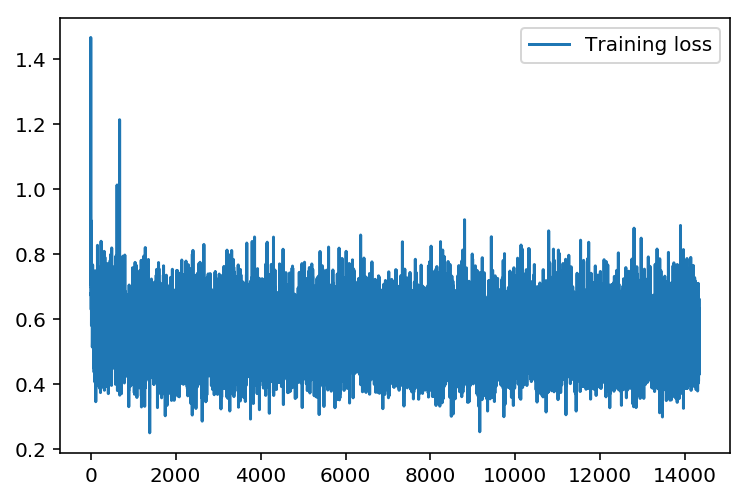

In [12]:
plt.plot(ctr_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

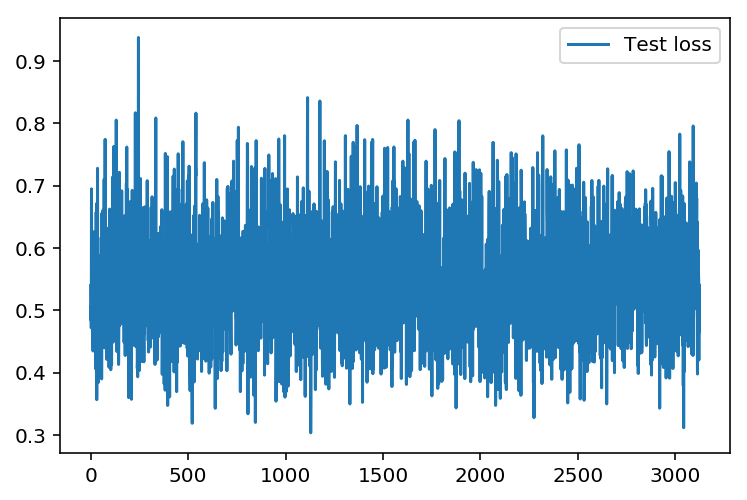

In [13]:
plt.plot(ctr_net.losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

#### 全数据的loss

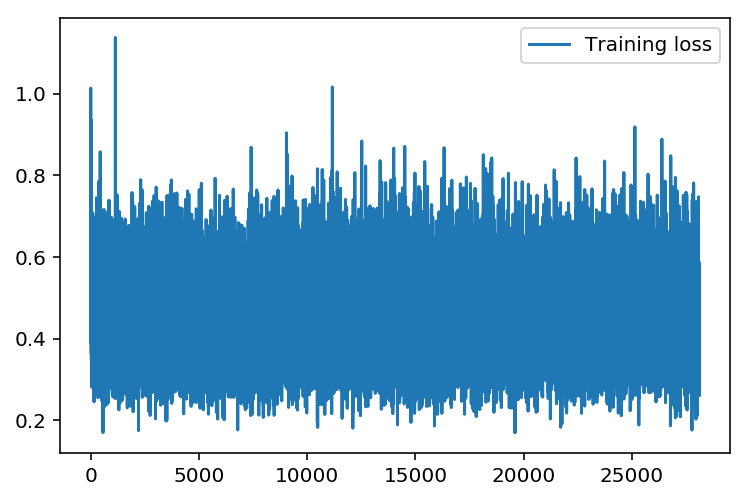

In [23]:
plt.plot(ctr_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

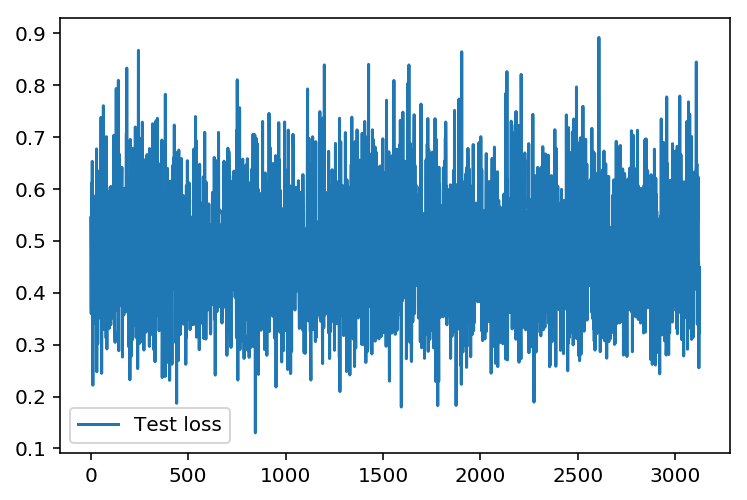

In [24]:
plt.plot(ctr_net.losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 使用测试数据进行测试

In [14]:
ffm_test_out_path = './te_ffm.out.logit'
fm_test_out_path = './te.fm.logits'
test_path = './data/test.txt'

ffm_test = pd.read_csv(ffm_test_out_path, header=None)    
ffm_test = ffm_test[0].values

fm_test = pd.read_csv(fm_test_out_path, header=None)    
fm_test = fm_test[0].values

test_data = pd.read_csv(test_path, header=None)    
test_data = test_data.values

pred_test_X = np.concatenate((ffm_test.reshape(-1, 1), fm_test.reshape(-1, 1), test_data), 1).astype(np.float32)

# pred_test_X = cc_test[:,0:-1]

In [69]:
save_params_with_name((pred_test_X), "pred_test_X")

In [ ]:
pred_test_X = load_params_with_name("pred_test_X")

In [275]:
len(pred_test_X)

1000000

In [15]:
ctr_net=ctr_network(1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sparse_input (InputLayer)       [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 32)       960000      sparse_input[0][0]               
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 13)]         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 832)          0           embedding_1[0][0]                
____________________________________________________________________________________________

#### 下采样训练的网络预测

In [16]:
ctr_net.predict_click(pred_test_X[0])

array([[0]], dtype=int32)

In [17]:
ctr_net.predict_click(pred_test_X[:20], 1)

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

#### 全数据训练的网络预测

In [25]:
ctr_net.predict_click(pred_test_X[0])

array([[0]], dtype=int32)

In [26]:
ctr_net.predict_click(pred_test_X[:20], 1)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

In [18]:
def get_test_batches(Xs, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end]

In [19]:
def predict_test(ctr_net, batch_size, axis = 1):
    if True:
        test_batches = get_test_batches(pred_test_X, batch_size)
        total_num = len(pred_test_X)
        
        pred_lst = []
        for batch_i in range(total_num // batch_size):
            x = next(test_batches)
            # Get Prediction
            clicked = ctr_net.predict_click(x, axis)
            pred_lst.append(clicked)
            if ((total_num // batch_size) + batch_i) % show_every_n_batches == 0:
                        print('Batch {:>4}/{}   mean click = {}'.format(
                            batch_i,
                            (total_num // batch_size),
                            np.mean(np.array(clicked))))
#         print(np.array(clicked))
        return pred_lst

#### 下采样训练的网络预测

In [20]:
pred_lst = predict_test(ctr_net, 64)

Batch    0/15625   mean click = 0.3125
Batch   25/15625   mean click = 0.359375
Batch   50/15625   mean click = 0.265625
Batch   75/15625   mean click = 0.28125
Batch  100/15625   mean click = 0.359375
Batch  125/15625   mean click = 0.328125
Batch  150/15625   mean click = 0.203125
Batch  175/15625   mean click = 0.34375
Batch  200/15625   mean click = 0.28125
Batch  225/15625   mean click = 0.359375
Batch  250/15625   mean click = 0.296875
Batch  275/15625   mean click = 0.21875
Batch  300/15625   mean click = 0.359375
Batch  325/15625   mean click = 0.375
Batch  350/15625   mean click = 0.328125
Batch  375/15625   mean click = 0.296875
Batch  400/15625   mean click = 0.328125
Batch  425/15625   mean click = 0.359375
Batch  450/15625   mean click = 0.40625
Batch  475/15625   mean click = 0.34375
Batch  500/15625   mean click = 0.3125
Batch  525/15625   mean click = 0.375
Batch  550/15625   mean click = 0.375
Batch  575/15625   mean click = 0.328125
Batch  600/15625   mean click = 0.2

Batch 5125/15625   mean click = 0.34375
Batch 5150/15625   mean click = 0.34375
Batch 5175/15625   mean click = 0.4375
Batch 5200/15625   mean click = 0.53125
Batch 5225/15625   mean click = 0.390625
Batch 5250/15625   mean click = 0.390625
Batch 5275/15625   mean click = 0.453125
Batch 5300/15625   mean click = 0.40625
Batch 5325/15625   mean click = 0.484375
Batch 5350/15625   mean click = 0.390625
Batch 5375/15625   mean click = 0.453125
Batch 5400/15625   mean click = 0.390625
Batch 5425/15625   mean click = 0.328125
Batch 5450/15625   mean click = 0.46875
Batch 5475/15625   mean click = 0.421875
Batch 5500/15625   mean click = 0.421875
Batch 5525/15625   mean click = 0.296875
Batch 5550/15625   mean click = 0.328125
Batch 5575/15625   mean click = 0.40625
Batch 5600/15625   mean click = 0.421875
Batch 5625/15625   mean click = 0.40625
Batch 5650/15625   mean click = 0.40625
Batch 5675/15625   mean click = 0.46875
Batch 5700/15625   mean click = 0.390625
Batch 5725/15625   mean cli

Batch 10225/15625   mean click = 0.375
Batch 10250/15625   mean click = 0.296875
Batch 10275/15625   mean click = 0.484375
Batch 10300/15625   mean click = 0.453125
Batch 10325/15625   mean click = 0.328125
Batch 10350/15625   mean click = 0.4375
Batch 10375/15625   mean click = 0.359375
Batch 10400/15625   mean click = 0.328125
Batch 10425/15625   mean click = 0.453125
Batch 10450/15625   mean click = 0.453125
Batch 10475/15625   mean click = 0.328125
Batch 10500/15625   mean click = 0.390625
Batch 10525/15625   mean click = 0.40625
Batch 10550/15625   mean click = 0.390625
Batch 10575/15625   mean click = 0.5
Batch 10600/15625   mean click = 0.328125
Batch 10625/15625   mean click = 0.375
Batch 10650/15625   mean click = 0.40625
Batch 10675/15625   mean click = 0.421875
Batch 10700/15625   mean click = 0.3125
Batch 10725/15625   mean click = 0.40625
Batch 10750/15625   mean click = 0.40625
Batch 10775/15625   mean click = 0.390625
Batch 10800/15625   mean click = 0.328125
Batch 10825

Batch 15250/15625   mean click = 0.34375
Batch 15275/15625   mean click = 0.390625
Batch 15300/15625   mean click = 0.34375
Batch 15325/15625   mean click = 0.3125
Batch 15350/15625   mean click = 0.4375
Batch 15375/15625   mean click = 0.328125
Batch 15400/15625   mean click = 0.3125
Batch 15425/15625   mean click = 0.40625
Batch 15450/15625   mean click = 0.484375
Batch 15475/15625   mean click = 0.34375
Batch 15500/15625   mean click = 0.484375
Batch 15525/15625   mean click = 0.453125
Batch 15550/15625   mean click = 0.359375
Batch 15575/15625   mean click = 0.4375
Batch 15600/15625   mean click = 0.328125


In [21]:
np.mean(pred_lst)

0.401381

#### 全数据训练的网络预测

In [27]:
pred_lst = predict_test(ctr_net, 64)

Batch    0/15625   mean click = 0.109375
Batch   25/15625   mean click = 0.15625
Batch   50/15625   mean click = 0.078125
Batch   75/15625   mean click = 0.125
Batch  100/15625   mean click = 0.046875
Batch  125/15625   mean click = 0.109375
Batch  150/15625   mean click = 0.03125
Batch  175/15625   mean click = 0.09375
Batch  200/15625   mean click = 0.078125
Batch  225/15625   mean click = 0.125
Batch  250/15625   mean click = 0.046875
Batch  275/15625   mean click = 0.046875
Batch  300/15625   mean click = 0.15625
Batch  325/15625   mean click = 0.171875
Batch  350/15625   mean click = 0.09375
Batch  375/15625   mean click = 0.109375
Batch  400/15625   mean click = 0.125
Batch  425/15625   mean click = 0.078125
Batch  450/15625   mean click = 0.171875
Batch  475/15625   mean click = 0.140625
Batch  500/15625   mean click = 0.046875
Batch  525/15625   mean click = 0.0625
Batch  550/15625   mean click = 0.109375
Batch  575/15625   mean click = 0.0625
Batch  600/15625   mean click = 0.

Batch 5150/15625   mean click = 0.15625
Batch 5175/15625   mean click = 0.109375
Batch 5200/15625   mean click = 0.15625
Batch 5225/15625   mean click = 0.09375
Batch 5250/15625   mean click = 0.140625
Batch 5275/15625   mean click = 0.1875
Batch 5300/15625   mean click = 0.140625
Batch 5325/15625   mean click = 0.140625
Batch 5350/15625   mean click = 0.15625
Batch 5375/15625   mean click = 0.15625
Batch 5400/15625   mean click = 0.171875
Batch 5425/15625   mean click = 0.09375
Batch 5450/15625   mean click = 0.203125
Batch 5475/15625   mean click = 0.125
Batch 5500/15625   mean click = 0.109375
Batch 5525/15625   mean click = 0.0625
Batch 5550/15625   mean click = 0.09375
Batch 5575/15625   mean click = 0.15625
Batch 5600/15625   mean click = 0.109375
Batch 5625/15625   mean click = 0.28125
Batch 5650/15625   mean click = 0.078125
Batch 5675/15625   mean click = 0.171875
Batch 5700/15625   mean click = 0.109375
Batch 5725/15625   mean click = 0.015625
Batch 5750/15625   mean click = 

Batch 10250/15625   mean click = 0.140625
Batch 10275/15625   mean click = 0.078125
Batch 10300/15625   mean click = 0.109375
Batch 10325/15625   mean click = 0.140625
Batch 10350/15625   mean click = 0.140625
Batch 10375/15625   mean click = 0.171875
Batch 10400/15625   mean click = 0.15625
Batch 10425/15625   mean click = 0.109375
Batch 10450/15625   mean click = 0.203125
Batch 10475/15625   mean click = 0.125
Batch 10500/15625   mean click = 0.125
Batch 10525/15625   mean click = 0.203125
Batch 10550/15625   mean click = 0.09375
Batch 10575/15625   mean click = 0.140625
Batch 10600/15625   mean click = 0.09375
Batch 10625/15625   mean click = 0.21875
Batch 10650/15625   mean click = 0.15625
Batch 10675/15625   mean click = 0.109375
Batch 10700/15625   mean click = 0.09375
Batch 10725/15625   mean click = 0.109375
Batch 10750/15625   mean click = 0.109375
Batch 10775/15625   mean click = 0.140625
Batch 10800/15625   mean click = 0.15625
Batch 10825/15625   mean click = 0.203125
Batch

Batch 15225/15625   mean click = 0.109375
Batch 15250/15625   mean click = 0.125
Batch 15275/15625   mean click = 0.140625
Batch 15300/15625   mean click = 0.109375
Batch 15325/15625   mean click = 0.109375
Batch 15350/15625   mean click = 0.1875
Batch 15375/15625   mean click = 0.078125
Batch 15400/15625   mean click = 0.15625
Batch 15425/15625   mean click = 0.109375
Batch 15450/15625   mean click = 0.125
Batch 15475/15625   mean click = 0.09375
Batch 15500/15625   mean click = 0.265625
Batch 15525/15625   mean click = 0.1875
Batch 15550/15625   mean click = 0.125
Batch 15575/15625   mean click = 0.171875
Batch 15600/15625   mean click = 0.09375


In [28]:
np.mean(pred_lst)

0.141264

## 总结

以上就是点击率预估的完整过程，没有进行完整数据的训练，并且有很多超参可以调整，从只跑了一次epoch的结果来看，验证集上的LogLoss是0.473（全数据训练）~0.546（下采样训练），其他数据都在70%~80%之间，这跟FFM、GBDT和FM网络训练的准确率差不多。

从两个网络的训练结果上看，全数据训练的网络更倾向于预测成0，因为全数据存在严重的数据不均衡，采用下采样的数据训练方式能够改善网络的训练效果。

## 扩展阅读

 - [`Code for the 3rd place finish for Avazu Click-Through Rate Prediction`](https://github.com/infinitezxc/kaggle-avazu)
 - [`Kaggle ： Display Advertising Challenge( ctr 预估 )`](http://blog.csdn.net/hero_fantao/article/details/42747281)
 - [`用机器学习对CTR预估建模`](http://blog.csdn.net/JR_lu/article/details/54836968)
 - [`Beginner's Guide to Click-Through Rate Prediction with Logistic Regression`](https://turi.com/learn/gallery/notebooks/click_through_rate_prediction_intro.html)
 - [`2nd place solution for Avazu click-through rate prediction competition`](https://github.com/owenzhang/kaggle-avazu)
 - [`常见计算广告点击率预估算法总结`](https://zhuanlan.zhihu.com/p/29053940?group_id=916424345212342272)
 - [`3 Idiots' Approach for Display Advertising Challenge`](https://github.com/guestwalk/kaggle-2014-criteo)
 - [`Solution to the Outbrain Click Prediction competition`](https://github.com/alexeygrigorev/outbrain-click-prediction-kaggle)
 - [`Deep Interest Network for Click-Through Rate Prediction`](https://arxiv.org/abs/1706.06978)
 - [`Learning Piece-wise Linear Models from Large Scale Data for Ad Click Prediction`](https://arxiv.org/abs/1704.05194)
 - [`重磅！阿里妈妈首次公开自研CTR预估核心算法MLR`](https://mp.weixin.qq.com/s/MtnHYmPVoDAid9SNHnlzUw)
 - [`阿里盖坤团队提出深度兴趣网络，更懂用户什么时候会剁手`](http://www.sohu.com/a/152084716_114877)
 - [`深入FFM原理与实践`](https://tech.meituan.com/deep-understanding-of-ffm-principles-and-practices.html)

## 今天的分享就到这里，就酱~